# Assignment — Community detection

In [1]:
import requests
from zlib import adler32
from IPython.display import clear_output
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import datasets
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Let us try to detect communities in Les Miserables graph.

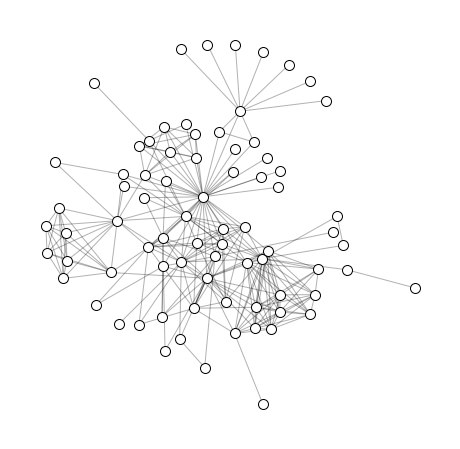

In [2]:
G = nx.Graph(nx.les_miserables_graph().edges)
G = nx.convert_node_labels_to_integers(G)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

### Task 1. Edge betweenness (0 points)

Let us apply Girvan Newman algorithm with edge betweenness. The idea is we cut edges with highest betweenness until the graph becomes disconnected. Use `nx.algorithms.community.girvan_newman` to find communities.

Write a function `edge_betweenness` that takes a graph and the number of divisions and returns np.array of (integer) labels of nodes in each iteration. The shape of the output is [n, m] where n is a number of iteration and m is a number of nodes.

In [3]:
from itertools import islice

def edge_betweenness(G, n):
    # YOUR CODE HERE
    m = len(G.nodes)
    labels = np.zeros((n, m))
    girvan_newman_comm = nx.algorithms.community.girvan_newman(G)

    for iter, communities in enumerate(islice(girvan_newman_comm, n)):
        for idx_com, community in enumerate(communities):
            labels[iter, list(community)] = idx_com

    return labels    

In [4]:
labels = edge_betweenness(G, 6)
assert labels.shape == (6, 77)
assert np.unique(labels[0]).shape == (2,)
assert np.unique(labels[0]).shape[0] < np.unique(labels[1]).shape[0] < np.unique(labels[5]).shape[0]
assert labels[5][22] == labels[5][23]
assert labels[5][31] == labels[5][34]

Let us draw Girvan Newman algorithm step-by-step.

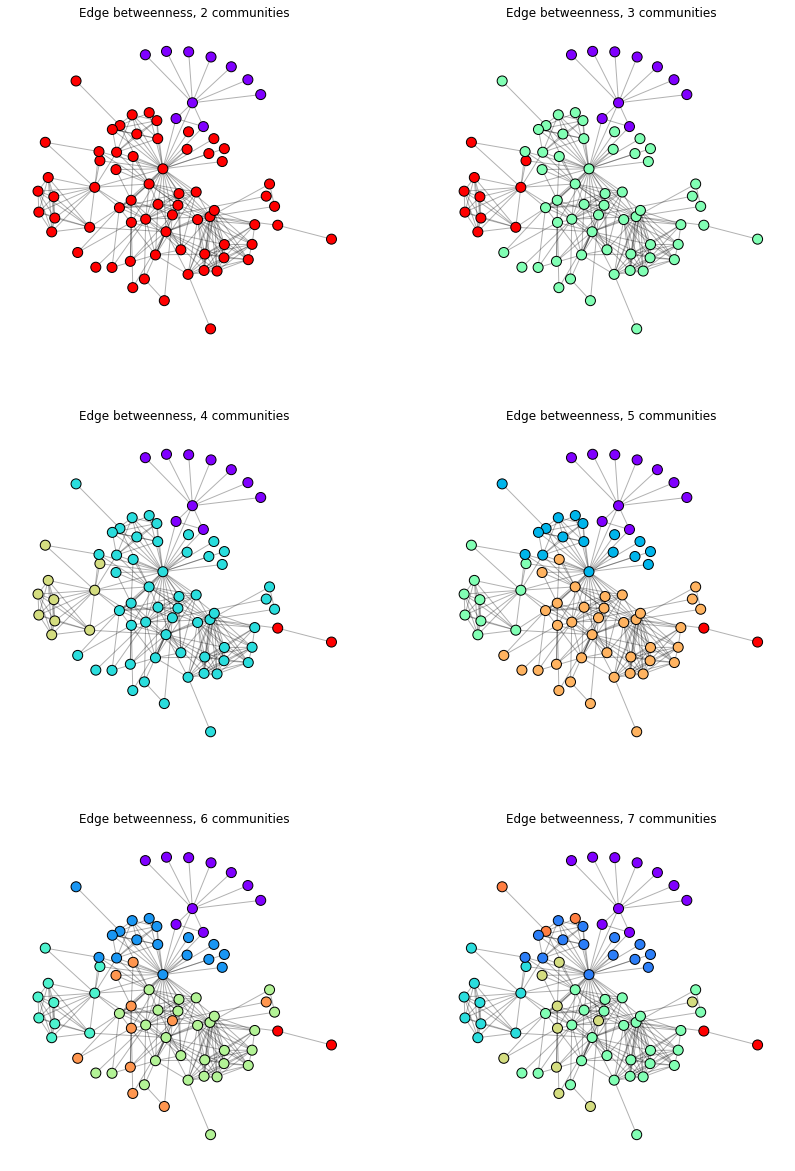

In [5]:
plt.figure(figsize=(7*2, 7*3))
colors = edge_betweenness(G, 6)
for i in range(colors.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

### Task 2. Modularity (0 points)

One of the best-known methods for community detection is called modularity. 

$$M = \frac{1}{2m}\sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m} \right) \delta(c_i, c_j)$$

where $m$ is the number of edges and $\delta(c_i, c_j)$ is Kronecker delta, it is equal 1 if nodes belong to the same community and 0 otherwise. Modularity is based on expected number of edges between nodes in Configuration model


$$\frac{k_ik_j}{2m-1} \approx \frac{k_ik_j}{2m}$$

<img src='http://networksciencebook.com/images/ch-04/figure-4-15.jpg' width=400>

Indeed, $k_i$ stubs can be connected to $k_j$ stubs between nodes $i$ and $j$ and there are $2m - 1$ ways to connect a stub for any other stub that can be approximated by $2m$ in a large network. That is, modularity measures the difference between expected number of edges and actual number of edges between nodes — the large modularity, the better partitioning. Let us implement modularity calculation.

`modularity` function takes an adjacency matrix and list of lists of nodes that belong to the same community and returns modularity score.

In [6]:
def modularity(A, communities):
    m = A.sum() / 2
    res = (A - expected_edges(A, m)) * kronecker(A, communities)
    return res.sum() / 2 / m

Write a function `expected_edges` that takes an adjacency matrix and number of edges `m` and returns a np.array with expected number of edges.

In [7]:
def expected_edges(A, m):
    # YOUR CODE HERE
    return A.sum(axis=0)[np.newaxis, :] * A.sum(axis=1)[:, np.newaxis] / 2 / m

In [8]:
A = nx.to_numpy_array(G)
m = G.number_of_edges()
ee = expected_edges(A, m)
assert ee.shape == A.shape
assert np.all(0 <= ee)
assert round(ee[10, 10], 2) == round(G.degree[10] * G.degree[10] / 2 / m, 2)

Write a function `kronecked` that takes an adjacency matrix and list of lists of nodes that belong to the same community and returns a np.array with Kronecked delta.

In [9]:
from itertools import product

def kronecker(A, communities):
    # YOUR CODE HERE
    delta = np.zeros_like(A)
    for community in communities:
        for c_i, c_j in product(community, community):
            delta[c_i, c_j] = 1
    return delta     

In [10]:
A = nx.to_numpy_array(G)
communities = [np.arange(0, 10), np.arange(10, len(G))]
kd = kronecker(A, communities)
assert kd.shape == A.shape
assert kd[0, 9] == 1 and kd[10, 11] == 1
assert kd[0, 10] == 0

Write a function `edge_betw_modularity` that takes a graph, number of iterations of Girvan Newman algorithm and returns a np.array with modularity after each iteration.

In [11]:
def edge_betw_modularity(G, n):
    # YOUR CODE HERE
    labels = edge_betweenness(G, n)
    A = nx.to_numpy_array(G)
    modularity_scores = []

    for iteration in labels:
        unique_communities = [set(np.where(iteration == idx_community)[0]) for idx_community in np.unique(iteration)]
        modularity_scores.append(modularity(A, unique_communities))

    return np.array(modularity_scores)

In [12]:
n_iterations = 20
mod_val = edge_betw_modularity(G, n_iterations)
assert mod_val.shape == (n_iterations, )
assert round(mod_val[0], 4) == 0.0746
assert round(mod_val[7], 4) == 0.4519

Let us draw dependency between a number of iteration and modularity.

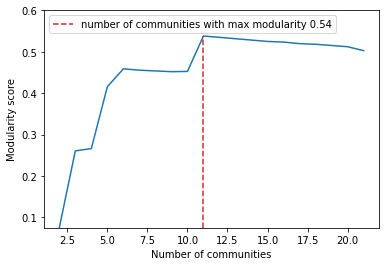

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, mod_val)
best_n = np.argmax(mod_val) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(mod_val))
plt.plot(
    [best_n, best_n], [min(mod_val), max(mod_val)], 
    'k--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.ylim((mod_val.min(), 0.6))
plt.show()

### Task 3. Eigenvalues of graph Laplacian (0 points)

There are a few auxiliary methods for graph generation.

In [14]:
def ring_lattice(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for i in range(1, int(k/2 + 1)):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G

In [15]:
def pair_graph(n):
    G = nx.disjoint_union(nx.complete_graph(n), nx.complete_graph(n))
    G.add_edge(0, n)
    return G

In [16]:
def triple_graph(n):
    G = nx.disjoint_union_all(
        [nx.complete_graph(n), nx.complete_graph(n), nx.complete_graph(n)]
    )
    G.add_edge(0, n)
    G.add_edge(n, n*2)
    G.add_edge(n*2, 0)
    return G

Graph Laplacian is

$$L = D - A$$

where $A$ is an adjacency matrix and $D$ is a diagonal matrix with node degrees. Eigenvalues and eigenvectors of Laplacian can give us information about structure of a graph. Let us see a few simple examples.

Write a function `eig_laplacian` that takes a graph and returns a tuple with 2 np.arrays: eigenvectors and eigenvalues of Laplacian. The both are ordered in ascending of eigenvalues. 

_Hints: any symmetric matrix has only real eigenvalues and eigenvectors. You can use `np.linalg.eigh` to calculate eigenvectors and eigenvalues in a symmetric matrix._

In [17]:
def eig_laplacian(G):
    # YOUR CODE HERE
    L = np.diag(list(dict(G.degree).values())) - nx.to_numpy_array(G)
    w, v = np.linalg.eigh(L)
    return v, w

In [18]:
emptyG = nx.empty_graph(10)
vecs, vals = eig_laplacian(emptyG)
assert vecs.sum() == 10
assert vals.sum() == 0
oneedgeG = nx.empty_graph(10)
oneedgeG.add_edge(0, 1)
vecs, vals = eig_laplacian(oneedgeG)
assert abs(vecs.round(4)[0, -1]) == abs(vecs.round(4)[1, -1]) == 0.7071
assert vals[0] < vals[-1]
vecs, vals = eig_laplacian(nx.complete_graph(10))
assert (vals == vals.real).sum() == vals.shape[0]
assert (vecs == vecs.real).sum() == vals.shape[0]**2
vecs, vals = eig_laplacian(ring_lattice(10, 2))
assert adler32(vals.round(4)[-1]) == 6815825
assert adler32(vals.round(4)[-2]) == 393479360

Consider some simple graphs and their Laplacian eigenvalues.

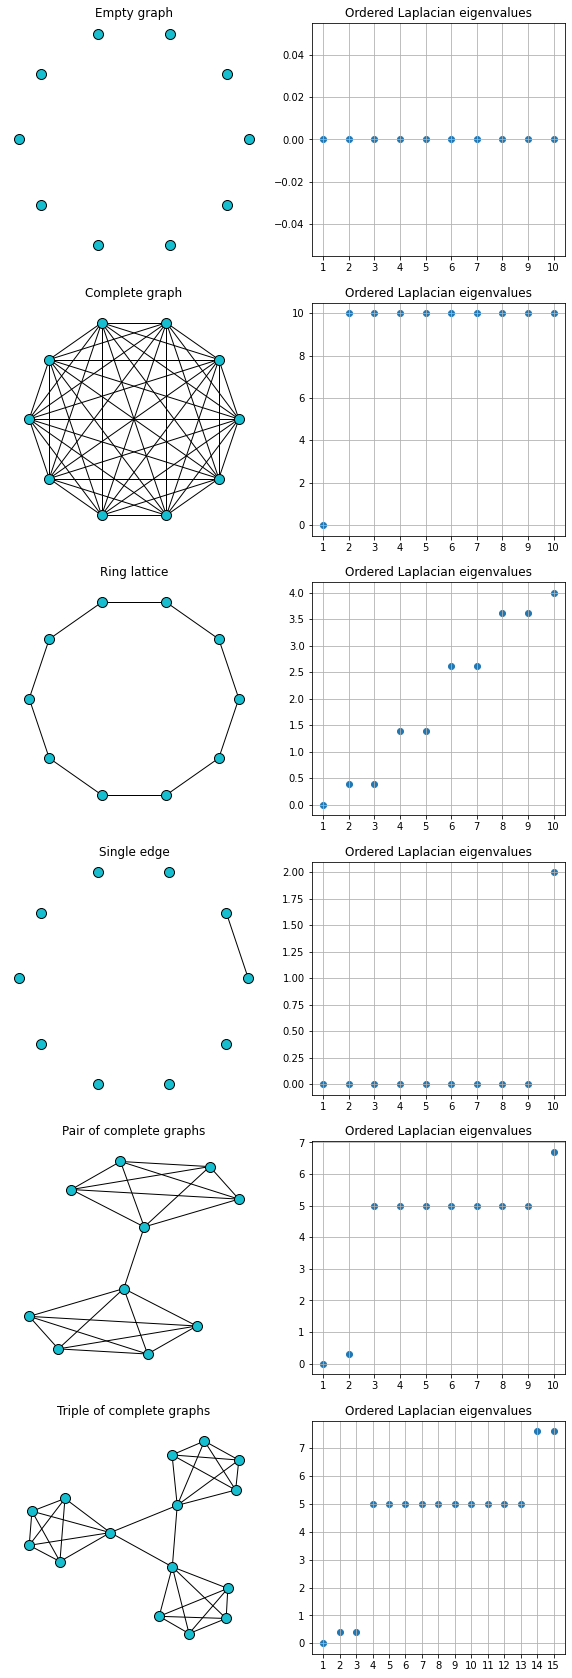

In [19]:
cases = []
cases.append([emptyG, 'Empty graph', nx.draw_circular])
cases.append([nx.complete_graph(10), 'Complete graph', nx.draw_circular])
cases.append([ring_lattice(10, 2), 'Ring lattice', nx.draw_circular])
cases.append([oneedgeG, 'Single edge', nx.draw_circular])
cases.append([pair_graph(5), 'Pair of complete graphs', nx.draw_kamada_kawai])
cases.append([triple_graph(5), 'Triple of complete graphs', nx.draw_kamada_kawai])

plt.figure(figsize=(5*2, 5*6))
i = 1
for iterG, title, designer in cases:
    plt.subplot(6, 2, i)
    i += 1
    designer(iterG, 
             node_color='tab:cyan', 
             edgecolors='black', 
             node_size=100)
    plt.title(title)
    plt.subplot(6, 2, i)
    i += 1
    vecs, vals = eig_laplacian(iterG)
    plt.scatter(np.arange(1, len(iterG) + 1), vals)
    plt.grid()
    plt.xticks(np.arange(1, len(iterG) + 1))
    plt.title('Ordered Laplacian eigenvalues')

We can observe that a number of zero eigenvalues is a number of connected component. $\lambda_2 = n$ in a complete graph. Also, the largest gap between eigenvalues indicates an optimal number of clusters. For example, the largest gap in a complete graph is between 1 and 2, then an optimal number of clusters is 1. Similarly, 2-3 gap is related to a pair graph, and 3-4 gap is related to a triple graph.

### Task 4. Spectral partitioning (0 points)

Spectral clustering is a very powerful algorithm for community detection that minimize graph cuts. It is based on Laplacian eigenvectors, in particular a sign of the second smallest eigenvector determines the partition of a graph into two clusters. Consider the following artificial dataset.

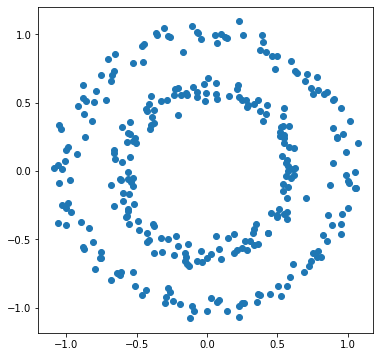

In [20]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1])
plt.show()

Let us isolate data points in center circle using spectral clustering. Any distance based dataset can be represented as a graph with edges between neighbors.

Write a function `custom_graph` that takes a np.array with x-y data points and returns a connected graph. 

_Hint: try to apply `sklearn.neighbors.kneighbors_graph`._

_Remark: you can introduce your own distance_

In [21]:
from sklearn.neighbors import kneighbors_graph

def custom_graph(data):
    # YOUR CODE HERE
    return nx.Graph(kneighbors_graph(data, 10))

In [22]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = custom_graph(circles)
assert circlesG.number_of_nodes() == 300
assert nx.is_connected(circlesG)

Let us draw values in second smallest eigenvector of Laplacian.

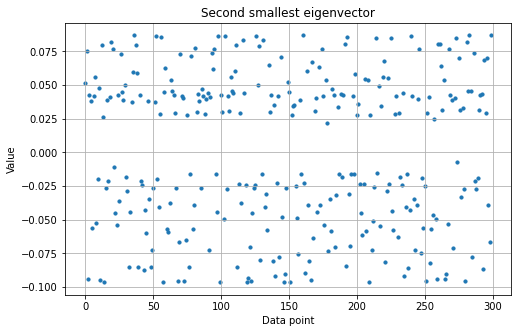

In [23]:
vecs, vals = eig_laplacian(circlesG)

plt.figure(figsize=(8, 5))
plt.scatter(np.arange(300), vecs[:, 1], s=10)
plt.title('Second smallest eigenvector')
plt.xlabel('Data point')
plt.ylabel('Value')
plt.grid()
plt.show()

Next, write a function `spectral_two_clusters` that takes np.array with ordered eigenvectors and returns np.array with labels of nodes.

In [24]:
def spectral_two_clusters(vecs):
    # YOUR CODE HERE
    return np.sign(vecs[:, 1])

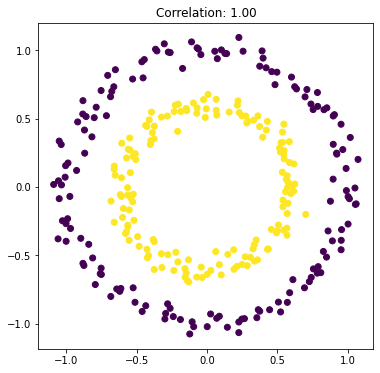

In [25]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = custom_graph(circles)
vecs, vals = eig_laplacian(circlesG)
labels = spectral_two_clusters(vecs)

assert abs(np.corrcoef(truth_labels, labels)[0, 1]) > 0.95

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=labels)
plt.title('Correlation: {:.2f}'.format(abs(np.corrcoef(truth_labels, labels)[0, 1])))
plt.show()

_Remark: there are two directions of graph construction: selection pairs of nodes to connect to each other, and choosing the weights of created edges. Set `factor=0.7` in `datasets.make_circles` and test yourself — try to achive 0.9 correlation. Combine `sklearn.neighbors.kneighbors_graph` with `scipy.spatial.distance_matrix` or `sklearn.metrics.pairwise.rbf_kernel`. Details are [here](http://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf)._

### Task 5. Laplacian Eigenmaps (3 points)

In the previous task, we saw how to split a graph into two parts. Let us consider a way to get more parts in the following graph.

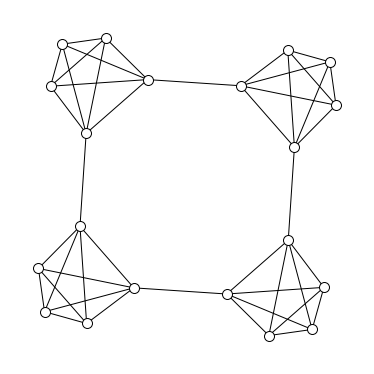

In [26]:
quadG = nx.disjoint_union_all([nx.complete_graph(5), 
                               nx.complete_graph(5),
                               nx.complete_graph(5),
                               nx.complete_graph(5)])
quadG.add_edge(0, 5)
quadG.add_edge(6, 10)
quadG.add_edge(11, 16)
quadG.add_edge(17, 1)

plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(
    quadG, 
    node_color='white', 
    edgecolors='black', 
    node_size=100)

Further splitting can be performed by different approaches. For example, we can repeat the clustering procedure on the both subgraphs separetely and choose a minimal graph cut and then repeat it again. Another way is to get Laplacian Eigenmaps and then apply KMeans. Let us consider how it works.

1. Compute _normalized_ Laplacian
$$L = D^{-1/2}(D - A)D^{-1/2}$$
2. Find the $K$ smallest eigenvectors (excluding the smallest)
3. Form the Laplacian eigenmaps — a matrix where columns are eigenvectors, rows are node embeddings
4. Put eigenmaps into KMeans
5. Label nodes by fitted KMeans

Write a function `norm_laplacian` that takes an adjacency matrix `A` and returns a normalized Laplacian.

In [27]:
def norm_laplacian(A):
    # YOUR CODE HERE
    degrees = A.sum(axis=0)
    D = np.diag(degrees)
    inv_D = np.diag(degrees ** (-0.5)) 
    return inv_D @ (D - A) @ inv_D

In [28]:
A = nx.to_numpy_array(quadG)
L = norm_laplacian(A)
assert L.shape == (20, 20)
assert np.diagonal(L).sum() == 20
assert round(L[:, 2].sum(), 4) == 0.0528

Write a function `spectral_embedding` that takes np.array with normalized Laplacian and returns np.array with Laplacian Eigenmaps. `n_components` is a number of vectors of the output.

In [29]:
def spectral_embedding(L, n_components):
    # YOUR CODE HERE
    _, v = np.linalg.eigh(L)
    return v[:, 1:(n_components+1)]

In [30]:
embedding = spectral_embedding(L, 3)
assert embedding.shape == (20, 3)
assert embedding[:, 0].max() > 0
assert embedding[:, 0].min() < 0
assert embedding[:, 1].max() > 0
assert embedding[:, 1].min() < 0
assert (embedding[:, 0] > 0).sum() == 10
assert (embedding[:, 1] > 0).sum() == 10
assert (embedding[:, 2] > 0).sum() == 10

Let us look at a pairplot of the spectral embedding.

In [31]:
def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L = norm_laplacian(A)
    embedding = spectral_embedding(L, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

In [32]:
embedding = spectral_embedding(L, 3)
labels = spectral_clustering(quadG, 4, 3)
assert np.all(labels[:5] == labels[0])
assert np.all(labels[5:10] == labels[5])
assert np.all(labels[10:15] == labels[10])
assert np.all(labels[15:20] == labels[15])

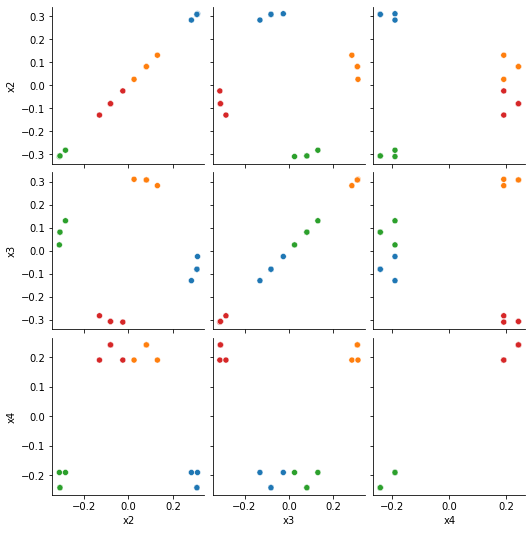

In [33]:
embedding = spectral_embedding(L, 3)
labels = spectral_clustering(quadG, 4, 3)
pair_data = pd.DataFrame(
    np.hstack([embedding, labels[:, None]]), 
    columns=['x2', 'x3', 'x4', 'label'])
pair_data.label = pair_data.label.astype('str')
p = sns.pairplot(
    pair_data,
    hue='label',
    diag_kind=None
)
p._legend.remove()
plt.show()

We can see four distinct clusters in the plots, that is why we use KMeans, but other clustering algorithms can also be applied here.

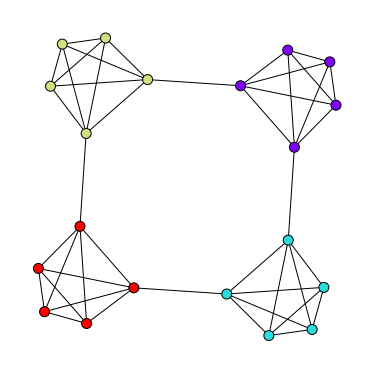

In [34]:
plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(
    quadG, 
    cmap=plt.cm.rainbow,
    node_color=labels, 
    edgecolors='black', 
    node_size=100)

Finally, let us see how spectral clustering works on the Les Miserables graph.

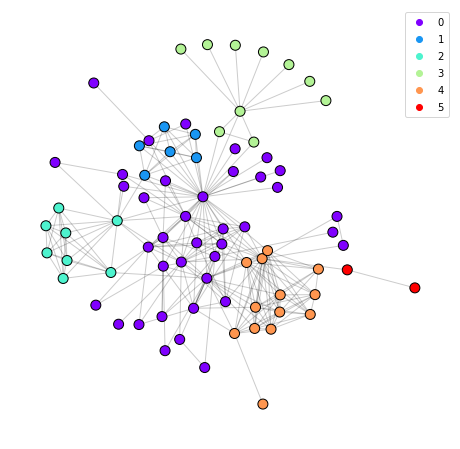

In [35]:
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=spectral_clustering(G, 6, 5), 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements())
plt.show()

### Task 6. Agglomerative clustering (2 points)

Agglomerative clustering is an iterative procedure that unions similar clusters using a similarity matrix, but since we will run `sklearn.cluster.AgglomerativeClustering`, we need to pass a _distance_ matrix. So, first we need to choose a similarity measure and then convert it into a distance. Let us do it via SimRank measure that is defined as follows: _two objects are considered to be similar if they are referenced by similar objects_. Since SimRank takes values on the interval [0, 1], let us define a distance as

$$\text{Distance}= 1 - \text{SimRank}$$

Write a function `simrank_distance` that takes a graph and returns a distance matrix based on SimRank. Use `nx.simrank_similarity`. The distance matrix should be _absolutely_ symmetric.

In [36]:
def simrank_distance(G):
    # YOUR CODE HERE
    simrank = nx.simrank_similarity_numpy(G)
    return 1 - (simrank + simrank.T) / 2

In [37]:
distance = simrank_distance(G)
assert distance.shape == (77, 77)
assert np.diagonal(distance).sum() == 0
assert np.allclose(distance, distance.T, rtol=0, atol=0)
assert distance[52, 68] <= distance[1, 19]
assert distance[45, 29] <= distance[38, 46]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: networkx.simrank_similarity_numpy is deprecated and will be removedin NetworkX 3.0, use networkx.simrank_similarity instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Then let us cluster nodes using `scipy.cluster.hierarchy.linkage`. The method takes distancies and returns an np.array with a matrix `Z` where every i-th row consists of
* `Z[i, 0]` and `Z[i, 1]` are indexes of combined clusters
* `Z[i, 2]` is the distance between combined clusters
* `Z[i, 3]` is the number of observations in combined clusters

Cluster with an index `n+i` is described in a i-th row of the matrix `Z`. Clusters with indexes less than `n+1` are initial nodes. The method `scipy.cluster.hierarchy.dendrogram` uses the matrix `Z` to plot a dendrogram. Let us look at a dendrogram of Les Miserables graph.

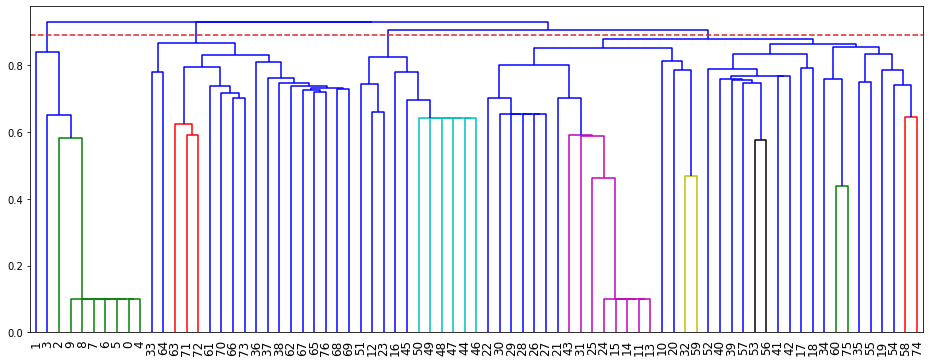

In [38]:
plt.figure(figsize=(16, 6))
linked = linkage(squareform(distance), 'complete')
dendrogram(linked, labels=list(G.nodes), 
           leaf_font_size=12)
plt.plot([0, 800], [0.89, 0.89], 'k--', c='tab:red')
plt.show()

Then we need to select a horizontal line that gives us a partitioning of the graph. There are two approaches: select the number of clusters, and select the maximal distance between clusters. For example, if we select a horicontal line with maximal distance 0.89 (a red line on the plot) then the number of clusters will be 4.

Write a function `agglomerative_clustering` that takes a distance matrix, maximal distance between clusters and returns an np.array with labels of clusters. Use `sklearn.cluster.AgglomerativeClustering` with complete linkage.

In [39]:
def agglomerative_clustering(distance, max_distance):
    # YOUR CODE HERE
    agg_clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=max_distance,
                                             linkage='complete',
                                             affinity='precomputed')
    agg_clustering.fit(distance)
    return agg_clustering.labels_

In [40]:
assert len(set(agglomerative_clustering(distance, 0.8))) == 17
assert len(set(agglomerative_clustering(distance, 0.89))) == 4

On the graph with maximal distance 0.87

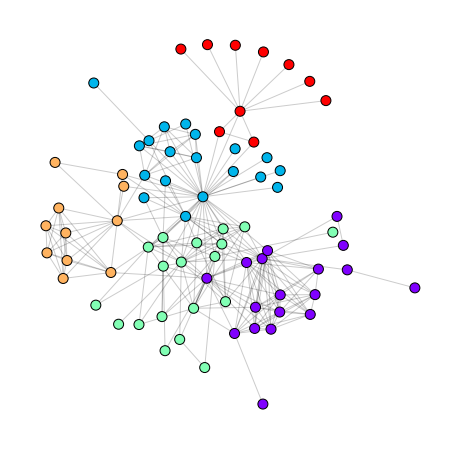

In [41]:
labels = agglomerative_clustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.show()

### Task 7. Louvain method (3 points)

Louvain method is one of the mostcited works in the community detection literature. It is a heuristic method based on modularity optimization for extracting the community structure of large networks. Let us consider this method on a ring of cliques.

In [42]:
def ring_of_cliques(csize, n):
    cliques = []
    for _ in range(n):
        cliques.append(nx.complete_graph(csize))
    G = nx.disjoint_union_all(cliques)
    for i in range(n):
        node_i = i * csize
        node_j = ((i + 1) * csize + 1) % (csize * n)
        G.add_edge(node_i, node_j)
    return G

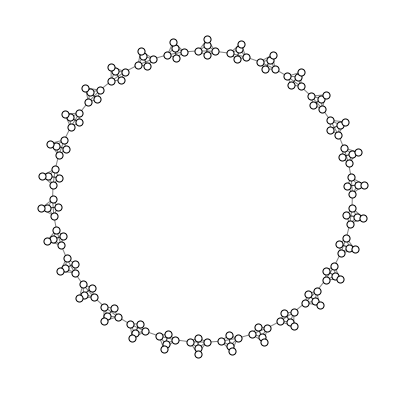

In [43]:
ringG = ring_of_cliques(csize=5, n=30)

plt.figure(figsize=(7, 7))
pos = nx.kamada_kawai_layout(ringG)
nx.draw_networkx_nodes(ringG, pos, node_color='white', 
                       edgecolors='black', node_size=50)
nx.draw_networkx_edges(ringG, pos, alpha=0.5)
plt.axis('off')
plt.show()

Let us compute expected number of edges for modularity calculation
$$e_{ij} = \frac{k_ik_j}{2m}$$
where $k_i$ is a degree of the node i and $m$ is the number of edges in a graph.

Write a function `expected_edges` that takes an adjacency matrix and number of edges `m` and returns a np.array with expected number of edges.

In [44]:
def expected_edges(A, m):
    # YOUR CODE HERE
    return A.sum(axis=0)[np.newaxis, :] * A.sum(axis=1)[:, np.newaxis] / 2 / m

In [45]:
A = nx.to_numpy_array(ringG)
m = ringG.number_of_edges()
ee = expected_edges(A, m)
assert ee.shape == A.shape
assert np.all(0 <= ee)
assert round(ee[10, 10], 2) == round(ringG.degree[10] * ringG.degree[10] / 2 / m, 2)

Modularity helps to select a community that a node should belong to. Consider community $c_\text{old}$ with a node $i$ and a community $c_\text{new}$ without a node $i$. The modularity gain is the change of modularity if we move a node $i$ from community $c_\text{old}$ into community $c_\text{new}$

$$\Delta M_i = \frac{1}{m}\left[ \sum_{j\in c_\text{new}} \left( A_{ij} - e_{ij} \right) - \sum_{j\in c_\text{old} \setminus \{i\}} \left( A_{ij} - e_{ij} \right) \right] $$

Write a function `modularity_gain` that takes an adjacency matrix `A`, expected edges `ee`, a moving node `mnode`, initial community `old_comm`, new community `new_comm` and number of edges `m`. It returns modularity gain. For simplicity, assume initial community does not contain a moving node.

In [46]:
def modularity_gain(A, ee, mnode, old_comm, new_comm, m):
    # YOUR CODE HERE
    old_modularity = sum(A[mnode, j] - ee[mnode, j] for j in old_comm + [mnode])
    new_modularity = sum(A[mnode, j] - ee[mnode, j] for j in new_comm + [mnode])
    return (new_modularity - old_modularity) / m

In [47]:
G = nx.complete_graph(6)
m1 = nx.algorithms.community.modularity(G, [[0, 1, 2], [3, 4, 5]])
m2 = nx.algorithms.community.modularity(G, [[0, 1], [2, 3, 4, 5]])
nx_gain = m2 - m1
nx_mod = nx.algorithms.community.modularity
del nx.algorithms.community.modularity
try:
    A = nx.to_numpy_array(G)
    m = G.number_of_edges()
    ee = expected_edges(A, m)
    gain = modularity_gain(A, ee, 2, [0, 1], [3, 4, 5], m)
except:
    raise AssertionError('networkx modularity usage')
finally:
    nx.algorithms.community.modularity = nx_mod
    del nx_mod
assert np.isclose(nx_gain, gain)

Louvain method

Phase 1: community unfolding
1. Put each node in its own community
2. For every node, calculate modularity gain and move it to the community with maximal modularity gain
3. Repeat until modularity stops increasing

Phase 2: network aggregation
1. Merge communities into ”super nodes”
2. Convert edges inside community into self loop, edges between communities into parallel edges

Repeat phases 1, 2 until modularity stops increasing.

In [48]:
def louvain_method(G):
    
    # Phase 1: community unfolding
    communities = unfolded_communities(G)

    # Create labels
    labels = np.zeros(len(G))
    for i, c in enumerate(communities):
        labels[c] = i
    
    # Phase 2: network aggregation
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        nextG.add_edge(labels[int(e[0])], labels[int(e[1])])
    
    # Shuffle label names for better visualization
    palette = np.unique(labels)
    key = np.random.permutation(palette)
    labels = key[np.digitize(labels, palette, right=True)]
    
    return communities, labels, nextG

Write a function `unfolded_communities` that takes a graph, performs Phase 1 and returns list of communities with nodes. For example, if there are two communitites: the first is [1,2] and the second is [3,4,5] then the output will be [[1,2],[3,4,5]].

In [49]:
def unfolded_communities(G):
    # Proposed template:
    A = nx.to_numpy_array(G)
    m = A.sum() / 2
    ee = expected_edges(A, m)
    communities = [[n] for n in G.nodes] # initial partition
    max_modularity_gain = 1
    while max_modularity_gain > 0:
        for node in G.nodes:
            '''
            1) Remove the node from the initial community.
            2) Iterate all neighboring communities and put a node 
               in the community with maximal modularity gain. If 
               there is no modularity gain, return the node into 
               the initial community.
            '''
            # YOUR CODE HERE
            for initial_community in communities:
                if node in initial_community:
                    initial_community.remove(node)
                    break

            best_community = None
            max_modularity_gain = 0

            for community in communities:
                if not set(community) & set(G.neighbors(node)):
                    continue

                community_modularity_gain = modularity_gain(A=A,
                                                            ee=ee,
                                                            mnode=node,
                                                            old_comm=initial_community,
                                                            new_comm=community,
                                                            m=m)
                
                if community_modularity_gain > max_modularity_gain:
                    best_community = community
                    max_modularity_gain = community_modularity_gain
            
            if best_community is None:
                initial_community.append(node)
            else:
                best_community.append(node)

    return [c for c in communities if len(c)]

In [50]:
ringG = ring_of_cliques(csize=5, n=30)
iterG = ringG.copy()
communities, labels, iterG = louvain_method(iterG)
assert len(set(labels)) == 30
assert len(set(labels[0:5])) == 1
assert len(set(labels[5:15])) == 2
assert iterG.number_of_nodes() == 30
for _ in range(2):
    communities, labels, iterG = louvain_method(iterG)
assert round(nx.algorithms.community.modularity(iterG, communities), 3) == 0.888

Let us see unfolding iterations. For every iteration we draw a graph where node color corresponds to the unfolded community.

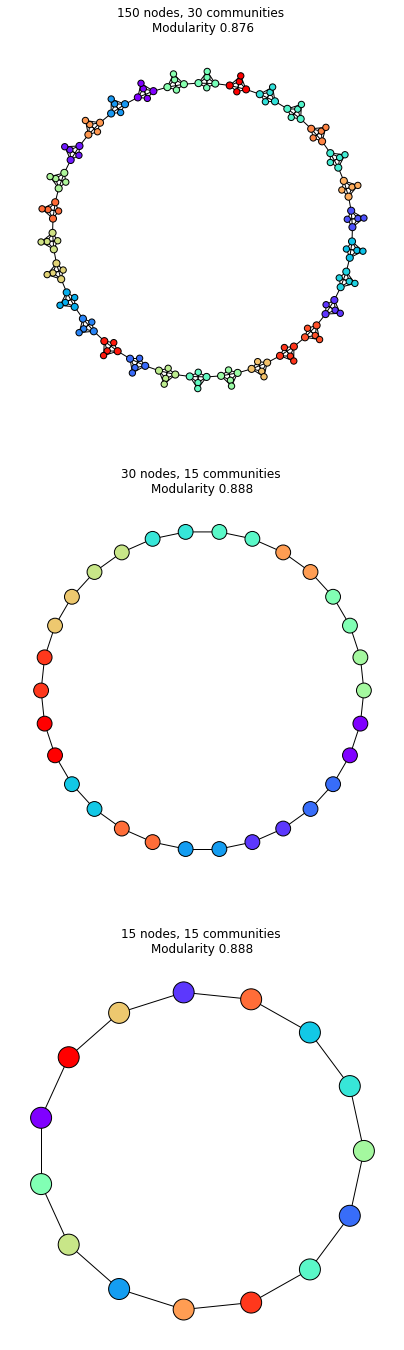

In [51]:
ringG = ring_of_cliques(csize=5, n=30)
iterG = ringG.copy()
plt.figure(figsize=(7, 8*3))
for i in range(3):
    plt.subplot(3, 1, i+1)
    communities, labels, nextG = louvain_method(iterG)
    iter_pos = nx.kamada_kawai_layout(iterG)
    degree = np.array([d for n, d in iterG.degree])
    nodes = nx.draw_networkx_nodes(
        iterG,
        iter_pos,
        cmap=plt.cm.rainbow,
        node_color=labels,
        edgecolors='black',
        node_size=10*degree
    )
    _iterG = iterG.copy()
    _iterG.remove_edges_from(nx.selfloop_edges(iterG))
    nx.draw_networkx_edges(
        _iterG,
        iter_pos,
        node_size=100, )
    plt.axis('off')
    plt.title(
        '{} nodes, {} communities \nModularity {:.3f}'.format(
            len(iterG), len(communities), nx.community.modularity(iterG, communities)))
    iterG = nextG

### Task 8. Label propagation (2 points)

The label propagation method is based on the simple idea: every node is initialized with a unique label and at every step each node adopts the label that most of its neighbors currently have. Here we use synchronous updating — we collect new labels and apply them simultaneously at the end of operation.

Write a function `update_labels` that takes a graph, np.array with labels in order `graph.nodes` and returns new labels. Label of the node is the random label occurring with the highest frequency among neighbors at the previous step. The order in which all the n nodes in the network are updated at each iteration is chosen randomly.

In [52]:
from collections import Counter

def update_labels(graph, labels):
    # YOUR CODE HERE
    shuffled_labels = list(graph.nodes)
    np.random.shuffle(shuffled_labels)
    new_labels = labels.copy()

    for node in shuffled_labels:
        freqs = Counter(labels[neighbor] for neighbor in graph.neighbors(node))
        max_freq = max(freqs.values())
        max_labels = [label for label, freq in freqs.items() if freq == max_freq]
        new_labels[node] = np.random.choice(max_labels)
    
    return new_labels

In [53]:
nodes = set()
for _ in range(100):
    G = nx.Graph([(0, 1), (0, 2)])
    labels = np.array(list(G.nodes))
    labels = update_labels(G, labels)
    nodes = nodes.union(labels)
assert set([0, 1, 2]) == nodes # check randomness
G = nx.karate_club_graph()
labels = np.array(list(G.nodes)) # initial partition
new_labels = update_labels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes)) # initial partition
for _ in range(5):
    labels = update_labels(G, labels)
new_labels = update_labels(G, labels)
assert len(set(new_labels - labels)) == 2
assert np.sum(list(set(new_labels - labels))) == 0

In [54]:
def plot_propagation(G, update_method, n=50):
    pos=nx.kamada_kawai_layout(G)
    labels = np.array(list(G.nodes))
    for i in range(n):
        clear_output(wait=True)
        labels = update_method(G, labels)
        plt.figure(figsize=(6, 6))
        nx.draw_networkx_nodes(G, pos=pos, node_color=labels, cmap=plt.cm.tab10_r)
        nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
        nx.draw_networkx_labels(G, pos=pos)
        plt.axis('off')
        plt.title('Iteration {}/{}'.format(i+1, n))
        plt.show()

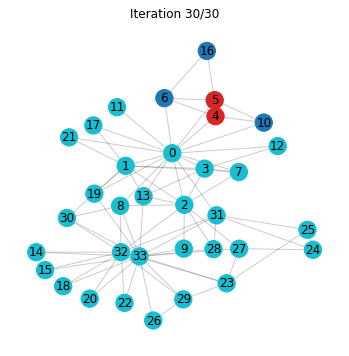

In [55]:
plot_propagation(nx.karate_club_graph(), update_labels, 30)

The problem however is that subgraphs in the network that are bi-partite or nearly bi-partite in structure lead to oscillations of labels.  This is especially true in cases where communities take the form of a star graph.

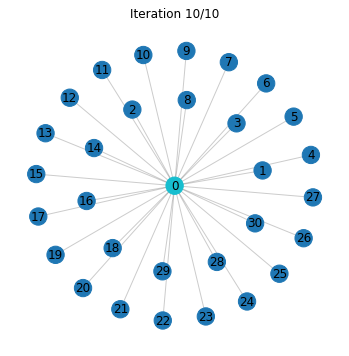

In [56]:
plot_propagation(nx.star_graph(30), update_labels, 10)

Hence we need to use asynchronous updating, when a label is immediately updated in the current iteration.

Write a function `async_update_labels` that makes asynchronous label updating. The order in which all the n nodes in the network are updated at each iteration is chosen randomly.

In [57]:
def async_update_labels(graph, labels):
    # YOUR CODE HERE
    shuffled_labels = list(graph.nodes)
    np.random.shuffle(shuffled_labels)
    shuffled_labels = shuffled_labels[:len(shuffled_labels) // 2]
    new_labels = labels.copy()

    for node in shuffled_labels:
        freqs = Counter(labels[neighbor] for neighbor in graph.neighbors(node))
        max_freq = max(freqs.values())
        max_labels = [label for label, freq in freqs.items() if freq == max_freq]
        new_labels[node] = np.random.choice(max_labels)
    
    return new_labels

In [58]:
G = nx.karate_club_graph()
labels = np.array(list(G.nodes)) # initial partition
new_labels = async_update_labels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes)) # initial partition
for _ in range(5):
    labels = async_update_labels(G, labels)
new_labels = async_update_labels(G, labels)
assert np.all(new_labels - labels == 0)

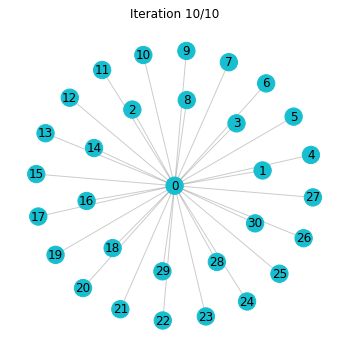

In [59]:
plot_propagation(nx.star_graph(30), async_update_labels, 10)

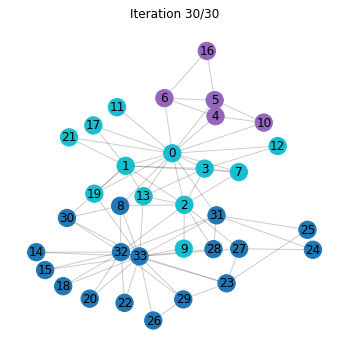

In [60]:
plot_propagation(nx.karate_club_graph(), async_update_labels, 30)